# Hurricane Data Project

### Project Description

The goal of this project is to use the HURDAT2 data to determine the hurricanes that have made landfall in Florida since 1900. We will output a report which indicates the max wind speed of this storm, along with the first date of landfall. We will use the hurdat2 data from https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt, and we will get geographical data from https://eric.clst.org/tech/usgeojson/. 

First, we will specify the project question. Landfall is defined as the event of a storm moving over land after being over water. This means that a storm can make multiple landfalls. This means that there is some ambiguity in the project question. There is a strict requirement and a liberal requirement as follows:

Strict requirement:
- The storm makes landfall in Florida
- The storm is at hurricane status while it is making landfall in Florida
- The date on the data is the date of the first landfall in Florida while the storm is a hurricane
- The wind speed on the data is the max wind speed while making the first landfall in Florida while the storm is a hurricane

Liberal requirement:
- The storm makes landfall in Florida
- The storm reaches hurricane status at some point
- The date on the data is the date of the first landfall in Florida
- The wind speed on the data is the max wind speed while making the first landfall in Florida

Any landfall:
- The storm makes landfall in Florida
- The storm may or may not reach hurricane status
- The date on the data is the date of the first landfall in Florida
- The wind speed on the data is the max wind speed of the storm

Additionally, the hurdat2 data gives latitude/longitude coordinates for hurricanes over time. We will assume that the hurricanes travel in straight lines between the points. 

### Strategy

The strategy for this project is to compare the path data for the hurricanes to the geographical data of Florida's border and mainland United States. We will use shapely objects to hold the data for both in a coordinate reference system of latitude/longitude lines. We will start with a geodataframe of storm location, which we will use to create a geodataframe of storm trajectory lines, and another geodataframe of Florida's border. By using shapely.GeoDataFrame.crosses, we will identify which lines cross the Florida border. 

The first issue with this plan is that storms can cross Florida borders both ways. In order to decide if an intersection means landfall, we will use the geodataframe of points associated with the intersection. We will check whether these points are inside the mainland US. If the storm starts on sea, then crosses the Florida border, it counts as a landfall event. This is true even if the storm ends at sea. This leaves us with a single unlikely edge case which we address at the end. This is also still true if the storm starts on an island off the coast of mainland US. The storm will still need to cross the ocean to make landfall. 

So the tasks required are the following:

1. Create a geodataframe representing the area of mainland US and a geodataframe representing the border of Flordia
2. Parse the hurdat2 file to create a dataframe of storms
3. Parse the hurdat2 file to create a geodataframe of storm locations and check which ones are inside mainland US.
4. Use the geodataframe of storm locations to create a geodataframe of storm trajectory lines
5. Find the intersection of the storm trajectory lines with Florida's border
6. Use the aggregated data to find out which types of landfall are represented by the lines

In [1]:
#We will get the HURDAT data directly from the website using requests
import requests

#For various numerical tasks
import numpy as np

#Pandas and geopandas will hold our data in dataframes and geodataframes
import pandas as pd
import geopandas as gpd

#Shapely will handle our geometry
from shapely.geometry import LineString

#For plotting
import matplotlib.pyplot as plt

## 1. Get Geographical Data

Text(0.5, 1.0, 'Mainland US Area')

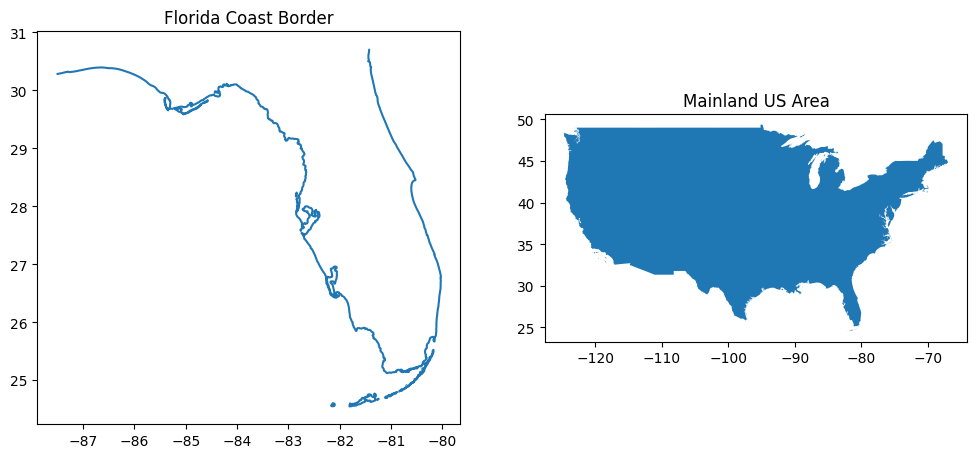

In [2]:
#We have this file of US border data from the link:  https://eric.clst.org/tech/usgeojson/
#gdf = GeoDataFrame
gdf = gpd.read_file('gz_2010_us_outline_500k.json')

#We will grab the x and y coordinates of each line of the border (beginning and end_
x1 = gdf.geometry.apply(lambda geom: geom.coords[0][0])
y1 = gdf.geometry.apply(lambda geom: geom.coords[0][1])
x2 = gdf.geometry.apply(lambda geom: geom.coords[1][0])
y2 = gdf.geometry.apply(lambda geom: geom.coords[1][1])

#We will select out this range to get rid of Alaska, Hawaii, and other islands
in_range = ((-130 < x1) & (x1 < -50)) & ((24 < y1) & (y1 < 50))
mainland = gdf[in_range]
#build_area() turns the border into an area, since we want to check whether points are inside
us_area = mainland.build_area()

#We further restrict the range to get the florida coast
in_range = ((-87.4 < x1) & (x1 < -79)) & ((24 < y1) & (y1 < 30.71))
florida_coast = gdf[in_range]

#See data plotted below
fig,ax=plt.subplots(1,2,figsize=(12,10))
florida_coast.plot(ax=ax[0])
ax[0].set_title("Florida Coast Border")
us_area.plot(ax=ax[1])
ax[1].set_title("Mainland US Area")

## 2. Parse hurdat2 file to get dataframe of storms

In [3]:
#First, we use requests to send a GET request to the link
url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
text = requests.get(url).text

#This gives us a long text string which we can split into a pandas Series of lines using \n
#Using pandas Series helps speed up our operations. pandas.Series.str methods are much faster than python iteration.
lines = pd.Series(text.split('\n')[:-1]).str.replace(' ','')

#The header lines in this hurdat2 file all start with AL for the atlantic basin.
is_header = lines.str.startswith('AL')




#Now we want to associate all of the storm location lines with the correct storm. To do this, we
#use np.where, and place the data in a dataframe for each line. The ffill() method adds the storm ids
#to the rows correctly - it repeats the previous storm id and replaces each NaN
linedf = pd.DataFrame({'raw_line':lines,'is_header':is_header})

#Storm ID is at the beginning of the header line, before the comma, so this gives storm id or NaN
linedf['storm_id'] = np.where(linedf['is_header'],linedf['raw_line'].str.split(',').str[0],np.nan)
linedf['storm_id']=linedf['storm_id'].ffill()




#Now we make a dataframe for just the header lines called dfh (DataFrameHeader or DataFrameHurricane).
#We will fill it out with the other information from the hurricane data. The line will give us the 
#Storm ID, Storm name, and the amount of rows of data.

#We take the header lines and split them by commas, renaming each section accordingly
dfh = lines[is_header].str.split(',',n=2,expand = True)
dfh = dfh.rename(columns={0: 'storm_id', 1: 'storm_name',2:'rows'})
#Two of the columns are numeric, and the final column needs to drop the last comma
dfh['rows'] = pd.to_numeric(dfh['rows'].str.replace(',',''))
#We need year to drop data before 1900
dfh['year'] = pd.to_numeric(dfh['storm_id'].str[4:])

#We want to index the storms by storm_id for joins later on
dfh=dfh.set_index('storm_id',drop=True)
dfh.head()

,storm_name,rows,year
storm_id,,,
AL011851,UNNAMED,14,1851
AL021851,UNNAMED,1,1851
AL031851,UNNAMED,1,1851
AL041851,UNNAMED,49,1851
AL051851,UNNAMED,16,1851


## 3. Parse hurdat2 file to get dataframe of storm points

In [4]:
#Now we parse the remaining non-header lines to fill a dataframe of storm points. 
#These lines are easier to separate into data, since each data point is separated by a comma
#The dataframe is created as dfp (DataFramePoints) from the nonheader lines
dfp = linedf[is_header == False]
#This turns each comma separated string into a seperate Series, which we rename
dfp = pd.concat([dfp,dfp['raw_line'].str.split(',',expand = True)],axis=1)
dfp = dfp.rename(columns={
    0: 'date', 1: 'hours', 2:'landfall_marker', 3:'status', 4:'latitude_N', 5:'longitude_E_old', 6:'wind_speed', 7: 'pressure'
})
#The columns starting at 8 are unnecessary, contianing the storm width. Perhaps in a future
#version we can plot with the with of the storms over time
dfp = dfp.drop(range(8,21),axis=1)



#Now we convert the data into its proper types. Each of these is done using a
#vectorized operation which helps parse large datasets quickly:

#The status column tells us what kind of storm it is, we want to know if it's a hurricane
dfp['is_hurricane'] = dfp['status'] == 'HU'

#Datetimes are handled in a specific way in pandas which is helpful for us.
dfp['datetime'] = pd.to_datetime(dfp['date'] + dfp['hours'],format='%Y%m%d%H%M')

#These columns are numeric
dfp['wind_speed'] = pd.to_numeric(dfp['wind_speed'])
dfp['pressure'] = pd.to_numeric(dfp['pressure'])
dfp['latitude_N'] = pd.to_numeric(dfp['latitude_N'].str[:-1]) #Remove N at the end
dfp['longitude_E'] = pd.to_numeric(dfp['longitude_E_old'].str[:-1])

#We handle the longitude column differently because it can be negative. We want to make it negative if it contained 
#a 'W' at the end, and positive if it had a 'E'. This will make sure it shows up correctly on the map, and aligns it
#with the geographical data that we have.
dfp['longitude_E'] = np.where(dfp['longitude_E_old'].str[-1] == 'E',dfp['longitude_E'],dfp['longitude_E']*-1)




#We want to use shapely to determine if our points are inside the mainland US. To do this, we will use this
#vectorized shapely function points_from_xy which is built for loading in large Series of data.
dfp = gpd.GeoDataFrame(dfp,geometry = gpd.points_from_xy(dfp['longitude_E'], dfp['latitude_N']),crs = us_area.crs)

#We don't need these columns anymore
dfp = dfp.drop(['longitude_E_old','raw_line','is_header','date','hours','longitude_E','latitude_N'],axis=1)

#Finally, we calculate whether the points are on land using within()
dfp['on_land'] = dfp.within(us_area.union_all())
dfp

,storm_id,landfall_marker,status,wind_speed,pressure,is_hurricane,datetime,geometry,on_land
1,AL011851,,HU,80,-999,True,1851-06-25 00:00:00,POINT (-94.8 28),False
2,AL011851,,HU,80,-999,True,1851-06-25 06:00:00,POINT (-95.4 28),False
3,AL011851,,HU,80,-999,True,1851-06-25 12:00:00,POINT (-96 28),False
4,AL011851,,HU,80,-999,True,1851-06-25 18:00:00,POINT (-96.5 28.1),False
5,AL011851,L,HU,80,-999,True,1851-06-25 21:00:00,POINT (-96.8 28.2),False
...,...,...,...,...,...,...,...,...,...
57216,AL192024,,TS,35,1001,False,2024-11-17 06:00:00,POINT (-87.5 16.5),False
57217,AL192024,,TS,35,1001,False,2024-11-17 12:00:00,POINT (-87.9 16.8),False
57218,AL192024,L,TS,35,1001,False,2024-11-17 14:00:00,POINT (-88.3 17),False
57219,AL192024,,TD,30,1003,False,2024-11-17 18:00:00,POINT (-89.1 17.4),False


One of our requirements is to only use storms after 1900. If there are any storms which are active during the new year, we will need to consider how to handle it, so we will check which storms are recorded within 2 months of the year change. We see below that the nearest storm is in the previous November, so we should be safe to just cut off all data before 1900.

In [5]:
dt = dfp['datetime']
firstdate = pd.to_datetime('1899-10-25 00:00:00')
lastdate = pd.to_datetime('1900-02-28 00:00:00')
in_range = (dt > firstdate) & (dt < lastdate)
dfp[in_range]

,storm_id,landfall_marker,status,wind_speed,pressure,is_hurricane,datetime,geometry,on_land
9541,AL091899,,TS,35,-999,False,1899-10-26 00:00:00,POINT (-78.8 16.2),False
9542,AL091899,,TS,35,-999,False,1899-10-26 06:00:00,POINT (-78.9 16.6),False
9543,AL091899,,TS,35,-999,False,1899-10-26 12:00:00,POINT (-79 17),False
9544,AL091899,,TS,35,-999,False,1899-10-26 18:00:00,POINT (-79.1 17.4),False
9545,AL091899,,TS,40,-999,False,1899-10-27 00:00:00,POINT (-79.2 17.8),False
9546,AL091899,,TS,40,-999,False,1899-10-27 06:00:00,POINT (-79.3 18.2),False
9547,AL091899,,TS,45,-999,False,1899-10-27 12:00:00,POINT (-79.4 18.5),False
9548,AL091899,,TS,50,-999,False,1899-10-27 18:00:00,POINT (-79.5 18.8),False
9549,AL091899,,TS,55,-999,False,1899-10-28 00:00:00,POINT (-79.6 19.1),False
9550,AL091899,,TS,60,-999,False,1899-10-28 06:00:00,POINT (-79.7 19.4),False


In [6]:
#Cut off all storm and point data before 1900:
dfh = dfh[dfh['year']>=1900]
dfp = dfp[dfp['datetime'].dt.year >= 1900]

## 4. Create trajectory lines

Our next goal is to create trajectory lines. The way we do this is to take the GeoSeries of points, and shift it backwards by one, so that the points align with the next point down the line. Then, when the points align, we can run vectorized functions which create lines quickly by their corresponding IDs. We shift the series of the points backwards instead of forwards so that the lines contain more information about where they are coming from, not where they are going (remember we need to know where it starts from). We connect that to the original Series of points to make pairs of points.

Then, we remove any pairs that represent different storms. It may seem like breaking up into storms first is more intuitive. The reason we take this approach is because iterating through python loops is slow, and it is much faster to work with all of the points at the same time. Finally, we run a vectorized loop that creates the lines out of the pairs. 

In [7]:
#First we create a dataframe of lines (DataFrameLines = dfl) variable, which will contain all the necessary 
#information from the first point on the line. This information will be necessary, because we will need to
#know the wind speed, datetime, and storm status (whether its a hurricane) WHILE its making landfall, not
#just in general.
#
#We need the storm_id for joins, and the on_land column because we need to know if it's crossing into or
#out of Florida. We will name on_land to starts_on_land because it represents the first point.
dfl = dfp[['storm_id', 'geometry','on_land','datetime','wind_speed','is_hurricane']].copy()
dfl = dfl.rename(columns={'on_land': 'starts_on_land'})

#Now we shift all the points backwards, and add it to our dataframe, so that each point aligns with the next
dfl['shifted_geo'] = dfl['geometry'].shift(-1)
#We will also shift the storm_ids, so that we know which lines represent storm paths and which are connecting
#different hurricanes. We then remove any entries that don't make sense.
dfl['shifted_storm_id'] = dfl['storm_id'].shift(-1)
dfl = dfl[dfl['shifted_storm_id'] == dfl['storm_id']]

#Now that we have only pairs of points representing actual trajectories, we make lines out of them.
new_lines_list = [LineString([start, end]) for start, end in zip(dfl['geometry'], dfl['shifted_geo'])]
#Drop uneccesary columns
dfl = dfl.drop(columns=['shifted_geo','geometry','shifted_storm_id'])
#Setting the list of lines into a GeoDataFrame helps us run operations faster and keep data together
dfl = gpd.GeoDataFrame(dfl, geometry=new_lines_list)
dfl

,storm_id,starts_on_land,datetime,wind_speed,is_hurricane,geometry
9600,AL011900,False,1900-08-27 00:00:00,35,False,"LINESTRING (-42.1 15, -43.4 15.2)"
9601,AL011900,False,1900-08-27 06:00:00,35,False,"LINESTRING (-43.4 15.2, -44.7 15.3)"
9602,AL011900,False,1900-08-27 12:00:00,35,False,"LINESTRING (-44.7 15.3, -45.6 15.4)"
9603,AL011900,False,1900-08-27 18:00:00,35,False,"LINESTRING (-45.6 15.4, -46.6 15.6)"
9604,AL011900,False,1900-08-28 00:00:00,35,False,"LINESTRING (-46.6 15.6, -47.9 15.8)"
...,...,...,...,...,...,...
57215,AL192024,False,2024-11-17 00:00:00,35,False,"LINESTRING (-87.1 16.4, -87.5 16.5)"
57216,AL192024,False,2024-11-17 06:00:00,35,False,"LINESTRING (-87.5 16.5, -87.9 16.8)"
57217,AL192024,False,2024-11-17 12:00:00,35,False,"LINESTRING (-87.9 16.8, -88.3 17)"
57218,AL192024,False,2024-11-17 14:00:00,35,False,"LINESTRING (-88.3 17, -89.1 17.4)"


## 5. Find locations of landfall

Text(0.5, 1.0, "Storm trajectory lines intersecting Florida's coast")

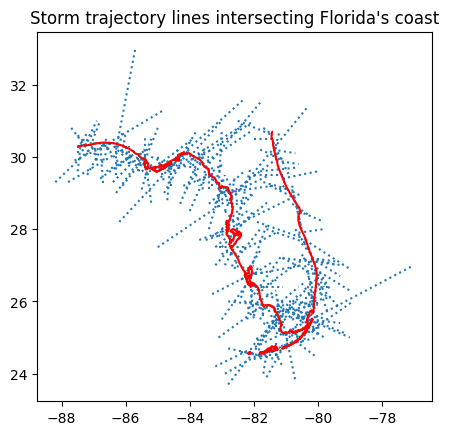

In [8]:
#With all of our preprocessing, this step is easy. Crosses() tells us which 
#lines intersect florida's coast and we already have starts_on_land. If it 
#starts in the ocean and crosses the border, then it counts as landfall.
dfl['crosses'] = dfl.crosses(florida_coast.union_all())
dfl['landfall'] = (dfl['starts_on_land'] == False) & dfl['crosses']

#Plot the lines along with Florida's coast to see:
fig,ax=plt.subplots()
dfl[dfl['landfall']].plot(linestyle='dotted',ax=ax)
florida_coast.plot(color='red',ax=ax)
ax.set_title("Storm trajectory lines intersecting Florida's coast")

## 6. Use aggregate functions to get correct data

In this section, we need to:
- Find out aggregate information for each storm like whether it reaches hurricane status, and what its max wind speed is
- Differentiate landfall events from strict landfall events
- Find out information like date and windspeed from the earliest landfall event of each storm
- Join the results in one dataframe indexed by storm_id

In [9]:
#The strict condition requires the storm to be a hurricane during the event, so we make a column for that:
dfl['strict_landfall'] = (dfl['landfall'] & dfl['is_hurricane'])

#The aggregate functions can be grouped together for more speed. In this function, we get information for
#each storm about whether it ever reaches hurricane status, using vectorized any(), and we get the max
#wind speed with vectorized max()
grouped_datap = dfp.groupby('storm_id').agg(
    is_hurricane = pd.NamedAgg(column = 'is_hurricane',aggfunc='any'),
    max_wind_speed = pd.NamedAgg(column = 'wind_speed',aggfunc='max'),
)

#Similar to the previous aggregate function, we are collecting for each storm whether there is at least
#one (any) landfall event, and whether there is at least one strict landfall event
grouped_datal = dfl.groupby('storm_id').agg(
    has_any_landfall=pd.NamedAgg(column='landfall', aggfunc='any'),
    has_strict_landfall = pd.NamedAgg(column='strict_landfall',aggfunc='any')
)

#To determine if a storm has a liberal landfall event, we ask if it has any landfall event, and if it reaches a hurricane.
is_liberal_event = grouped_datal['has_any_landfall'] & grouped_datap['is_hurricane']




#It is harder to find out information from the earliest landfall event. Most aggregate functions only work quickly over a single column,
#so we use the vectorized idxmin() to find the indices of the minimum (earliest) datetime. Then we use these indices to get the information
#we need out of other columns

#Gets the index of the earliest landfall for each storm
first_landfall_indices = dfl[dfl['landfall']].groupby('storm_id')['datetime'].idxmin()
#Creates a dataframe out of those indices, and returns datetime and wind_speed (here meaning the datetime/windspeed at that landfall)
#Note that this dataframe only includes those storms that do have a landfall event.
landfall_data = dfl.loc[first_landfall_indices][['datetime','wind_speed','storm_id']].set_index('storm_id')[['datetime', 'wind_speed']]
#Renames the columns to indicate the specificity
landfall_data = landfall_data.rename(columns={'datetime': 'landfall_date', 'wind_speed': 'wind_speed_at_landfall'})

#These next three lines are nearly the same as the preivous, except selecting out strict lanfall events instead
first_strict_landfall_indices = dfl[dfl['strict_landfall']].groupby('storm_id')['datetime'].idxmin()
strict_landfall_data = dfl.loc[first_strict_landfall_indices][['datetime','wind_speed','storm_id']].set_index('storm_id')[['datetime', 'wind_speed']]
strict_landfall_data = strict_landfall_data.rename(columns={'datetime': 'strict_landfall_date', 'wind_speed': 'strict_wind_speed_at_landfall'})

#Luckily, these results are already indexed by storm_id, so we can join them all directly. The landfall_data and 
#strict_landfall_data will not be populated for every storm_id, so we use fillna(0) to fill in 0 for missing values.
combined_storm_data = dfh.join(landfall_data).fillna(0).join(strict_landfall_data).fillna(0).join(grouped_datap).fillna(0).join(grouped_datal).fillna(False)

#This one is a Series, so it's joined differently
combined_storm_data['has_liberal_landfall'] = combined_storm_data.index.map(is_liberal_event).fillna(False)

print(f"Amount of hurricanes that have liberal landfall: {combined_storm_data['has_liberal_landfall'].sum()}"
    f"\nAmount of hurricanes that have strict landfall: {combined_storm_data['has_strict_landfall'].sum()}"
    f"\nAmount of storms that have landfall: {combined_storm_data['has_any_landfall'].sum()}"
)

combined_storm_data = combined_storm_data[combined_storm_data['has_any_landfall']]
#combined_storm_data.to_csv('combined_storm_data.csv')
combined_storm_data

Amount of hurricanes that have liberal landfall: 107
Amount of hurricanes that have strict landfall: 74
Amount of storms that have landfall: 212


,storm_name,rows,year,landfall_date,wind_speed_at_landfall,strict_landfall_date,strict_wind_speed_at_landfall,is_hurricane,max_wind_speed,has_any_landfall,has_strict_landfall,has_liberal_landfall
storm_id,,,,,,,,,,,,
AL061900,UNNAMED,24,1900,1900-10-12 00:00:00,40.0,0,0.0,False,40,True,False,False
AL011901,UNNAMED,21,1901,1901-06-13 18:00:00,35.0,0,0.0,False,35,True,False,False
AL041901,UNNAMED,71,1901,1901-08-10 18:00:00,40.0,0,0.0,True,80,True,False,True
AL081901,UNNAMED,44,1901,1901-09-17 18:00:00,50.0,0,0.0,True,70,True,False,True
AL101901,UNNAMED,48,1901,1901-09-28 00:00:00,40.0,0,0.0,False,45,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
AL172022,NICOLE,26,2022,2022-11-10 07:45:00,65.0,2022-11-10 07:45:00,65.0,True,65,True,True,True
AL102023,IDALIA,54,2023,2023-08-30 09:00:00,115.0,2023-08-30 09:00:00,115.0,True,115,True,True,True
AL042024,DEBBY,35,2024,2024-08-05 11:00:00,70.0,2024-08-05 11:00:00,70.0,True,70,True,True,True
